# Neural Scaling Laws: A Pedagogical Guide

**Understanding How Neural Network Performance Scales with Resources**

---

## Overview

This notebook explores **neural scaling laws** - empirical power law relationships that describe how model performance improves with:
- **Model Size (N)**: Number of parameters
- **Dataset Size (D)**: Number of training tokens
- **Compute Budget (C)**: Total FLOPs used during training

### Key Papers:
1. **Kaplan et al. (2020)**: Scaling Laws for Neural Language Models
2. **Hoffmann et al. (2022)**: Training Compute-Optimal Large Language Models (Chinchilla)
3. **Hestness et al. (2017)**: Deep Learning Scaling is Predictable, Empirically

### Learning Objectives:
By the end of this notebook, you will understand:
1. The fundamental power law relationships governing neural network training
2. How to optimally allocate compute between model size and training data
3. Why larger models are more sample-efficient
4. The trade-offs between training-optimal and inference-optimal strategies

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../../')
# Import our scaling laws module
from src.dlf.theory.scaling_laws import (
    ScalingLaws,
    plot_single_factor_slices,
    visualize_compute_optimal_frontier,
    demonstrate_sample_efficiency,
    print_summary
)

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("Scaling Laws Module Loaded Successfully!")

Scaling Laws Module Loaded Successfully!


## Part 1: The Fundamental Scaling Law Equation

### The Basic Formula

Neural scaling laws follow a simple power law relationship:

$$L(N, D, C) \approx L_\infty + A \cdot N^{-\alpha} + B \cdot D^{-\beta} + E \cdot C^{-\gamma}$$

where:
- **L** = Loss (lower is better)
- **N** = Number of parameters
- **D** = Number of training tokens
- **C** = Compute budget (FLOPs)
- **L∞** = Irreducible loss (noise floor)
- **α, β, γ** = Scaling exponents (typically 0.05-0.10)
- **A, B, E** = Amplitude constants

### Key Insights:

1. **Power Law Decay**: Loss decreases as a power of the resource, not exponentially
2. **Diminishing Returns**: Each 10x increase in resource gives progressively smaller improvements
3. **Irreducible Loss**: There's a theoretical floor (L∞) below which we cannot go
4. **Log-Log Linearity**: On log-log plots, these relationships appear as straight lines

Let's create a ScalingLaws object with empirically-derived parameters:

In [2]:
# Initialize ScalingLaws with empirically-derived parameters from Kaplan et al. (2020)
scaling = ScalingLaws(
    L_inf=1.69,    # Irreducible loss
    A=406.4,       # Parameter amplitude
    alpha=0.076,   # Parameter exponent
    B=410.7,       # Data amplitude
    beta=0.095,    # Data exponent
    E=1.8,         # Compute amplitude
    gamma=0.037    # Compute exponent
)

print("Scaling Laws Initialized with Parameters:")
print(f"  α (parameter exponent):  {scaling.alpha:.3f}")
print(f"  β (data exponent):       {scaling.beta:.3f}")
print(f"  γ (compute exponent):    {scaling.gamma:.3f}")
print(f"  L∞ (irreducible loss):   {scaling.L_inf:.2f}")
print("\nThese parameters were fit from training hundreds of language models")

Scaling Laws Initialized with Parameters:
  α (parameter exponent):  0.076
  β (data exponent):       0.095
  γ (compute exponent):    0.037
  L∞ (irreducible loss):   1.69

These parameters were fit from training hundreds of language models


## Part 2: Single-Factor Scaling Laws

Now let's visualize how loss scales with each resource **independently**:

### What to Expect:
- **Parameter Scaling**: Loss vs Model Size (N)
- **Data Scaling**: Loss vs Training Tokens (D)
- **Compute Scaling**: Loss vs Total FLOPs (C)

Each plot shows the relationship on **log-log axes**, where power laws appear as straight lines.


PLOTTING SINGLE-FACTOR SCALING LAWS

ELASTICITIES (% change in loss per 10x increase in resource)
Parameter elasticity: ε_N = -α = -0.076
  → 10x more parameters reduces loss by 16.1%

Data elasticity: ε_D = -β = -0.095
  → 10x more data reduces loss by 19.6%

Compute elasticity: ε_C = -γ = -0.037
  → 10x more compute reduces loss by 8.2%


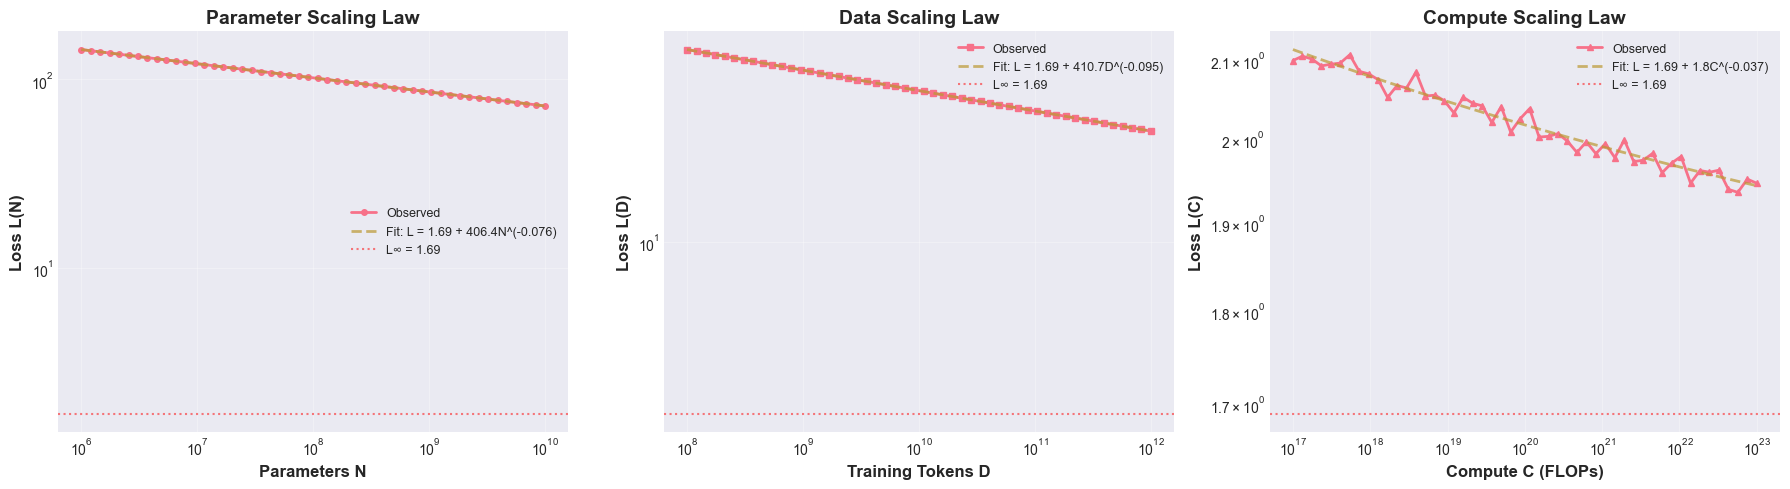

In [3]:
# Plot single-factor scaling laws
fig, axes = plot_single_factor_slices(scaling)
plt.savefig('scaling_laws_single_factor.png', dpi=300, bbox_inches='tight')
plt.show()

### Understanding the Plots

#### Key Observations:

1. **Straight Lines on Log-Log**: All three relationships follow power laws (straight lines on log-log plots)

2. **Different Exponents**:
   - **Data (β ≈ 0.095)** has the steepest slope → most effective at reducing loss
   - **Parameters (α ≈ 0.076)** has moderate impact
   - **Compute (γ ≈ 0.037)** has the shallowest slope

3. **Irreducible Loss (L∞)**: The red dotted line shows the theoretical floor

4. **Elasticities**: The % loss reduction per 10x resource increase
   - 10x more data → ~20% loss reduction
   - 10x more parameters → ~15% loss reduction
   - 10x more compute → ~8% loss reduction

#### Why is compute less efficient?

Because compute (C) is used for **both** training bigger models (N↑) and training longer (D↑). The compute exponent γ is actually related to α and β through the optimal allocation.

## Part 3: Compute-Optimal Allocation (Chinchilla Scaling)

### The Central Question:

**Given a fixed compute budget C, how should we split it between:**
- **Model size (N)**: Bigger models with more parameters
- **Training data (D)**: Training for more steps/tokens

### The Answer: Chinchilla Scaling

Hoffmann et al. (2022) showed that the optimal allocation is:

$$N^* \propto C^{0.50}$$
$$D^* \propto C^{0.50}$$

**Key Insight**: For optimal performance, model size and training data should **scale equally**!

- Double your compute → 1.4x bigger model **and** 1.4x more training
- This is called the **compute-optimal frontier** or **Chinchilla scaling**

Let's visualize this:


PLOTTING COMPUTE-OPTIMAL ALLOCATION (CHINCHILLA)


/Users/oualid/Documents/Teaching/Baruch/DL_for_Finance/repo/DLinFinance_BaruchMFE2025/src/notebooks/theory/../../../src/dlf/theory/scaling_laws.py:377: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()



COMPUTE-OPTIMAL ALLOCATION INSIGHTS
Envelope exponent: η = αβ/(α+β) = 0.0422

Chinchilla Strategy (Compute-Optimal Training):
  • N ∝ C^0.556
  • D ∝ C^0.444
  • Balanced scaling: double compute → ~1.4x both N and D

Inference-Optimal Strategy (Deployment Focus):
  • N ∝ C^0.45 (smaller models)
  • D ∝ C^0.55 (trained longer)
  • Minimizes serving costs after training


/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_66722/816500895.py:3: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.savefig('scaling_laws_chinchilla.png', dpi=300, bbox_inches='tight')
/Users/oualid/miniconda3/envs/mimesis/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


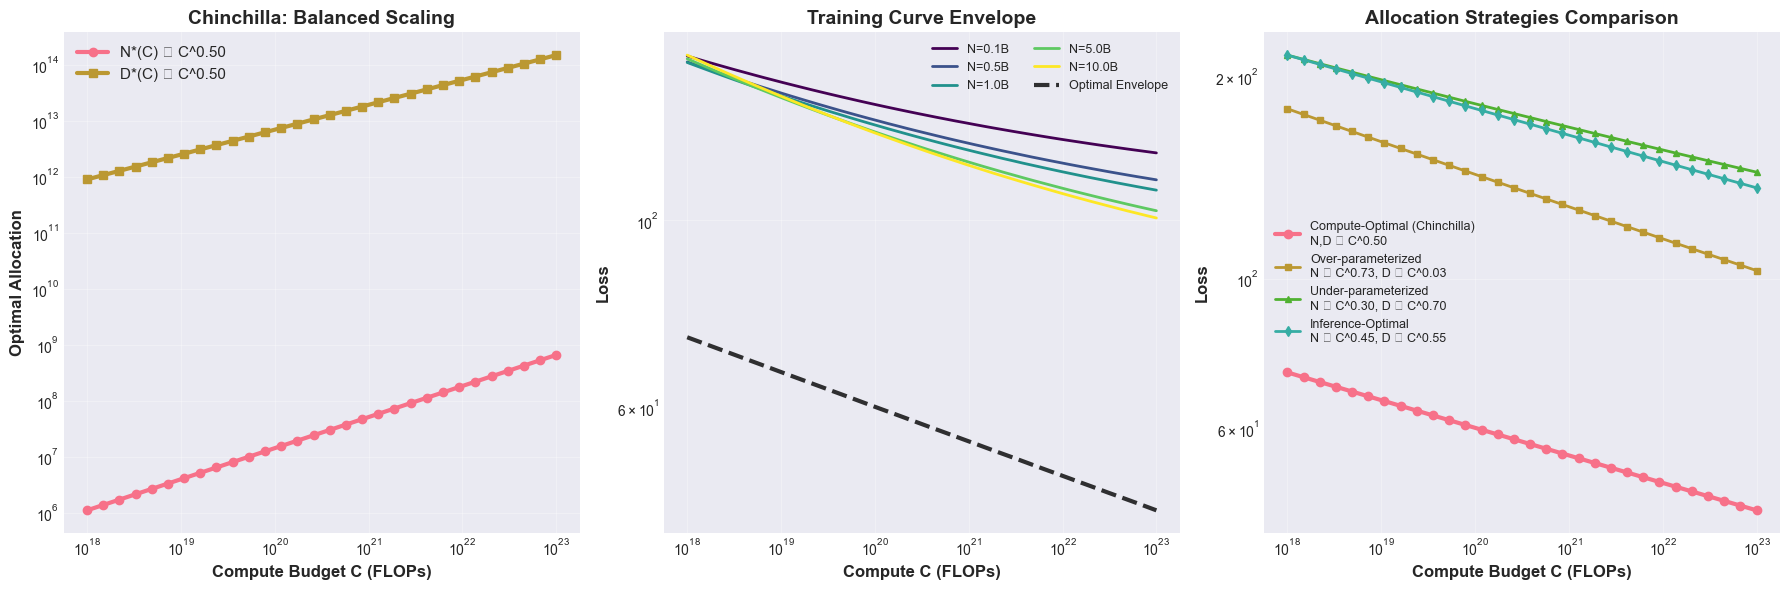

In [4]:
# Visualize compute-optimal allocation
fig = visualize_compute_optimal_frontier(scaling)
plt.savefig('scaling_laws_chinchilla.png', dpi=300, bbox_inches='tight')
plt.show()

### Understanding the Chinchilla Plots

#### Plot 1: Optimal Allocation
Shows how N and D should grow with compute budget C:
- Both follow C^0.50 (45-degree angle on log-log plot)
- This is **balanced scaling**: neither N nor D dominates

#### Plot 2: Training Curve Envelope
Shows loss vs compute for different model sizes:
- Each colored line = a fixed model size trained with varying amounts of data
- **Black dashed line** = the optimal envelope (Chinchilla frontier)
- No single model size is optimal everywhere - you need to scale both N and D!

#### Plot 3: Allocation Strategies Comparison

Compare different strategies:

1. **Compute-Optimal (Chinchilla)**: N,D ∝ C^0.50
   - Best loss per FLOP during training
   - Balanced approach

2. **Over-parameterized**: N ∝ C^0.73, D ∝ C^0.03
   - Large models, minimal training
   - Wastes compute on undertrained models
   - This was common before Chinchilla!

3. **Under-parameterized**: N ∝ C^0.30, D ∝ C^0.70
   - Small models, extensive training
   - Hits capacity limits of small models

4. **Inference-Optimal**: N ∝ C^0.45, D ∝ C^0.55
   - Smaller models, trained longer
   - Better for **deployment** (lower serving costs)
   - Slightly worse training efficiency

### Historical Context

Many pre-Chinchilla models (like GPT-3) were **over-parameterized**:
- GPT-3 (175B parameters) trained on 300B tokens
- Chinchilla optimal: 70B parameters trained on 1.4T tokens
- **Same compute, better performance with Chinchilla allocation!**

## Part 4: Sample Efficiency

### A Surprising Discovery

One of the most important findings from scaling laws is that **larger models are more sample-efficient**:
- They achieve the same loss with fewer training examples
- This reverses the traditional ML intuition that bigger models need more data!

### Why Does This Happen?

Larger models can:
1. **Learn faster**: Extract more information from each training example
2. **Generalize better**: Form better internal representations
3. **Transfer knowledge**: Apply patterns across diverse contexts

Let's demonstrate this phenomenon:

/Users/oualid/Documents/Teaching/Baruch/DL_for_Finance/repo/DLinFinance_BaruchMFE2025/src/notebooks/theory/../../../src/dlf/theory/scaling_laws.py:467: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()



DEMONSTRATING SAMPLE EFFICIENCY

SAMPLE EFFICIENCY ANALYSIS
Target loss: 2.0

Tokens needed to reach target:
     0.1B params:   1000.0B tokens ( 1.0x faster,   0.0% reduction)
     0.5B params:   1000.0B tokens ( 1.0x faster,   0.0% reduction)
     1.0B params:   1000.0B tokens ( 1.0x faster,   0.0% reduction)
     5.0B params:   1000.0B tokens ( 1.0x faster,   0.0% reduction)
    10.0B params:   1000.0B tokens ( 1.0x faster,   0.0% reduction)

Key Insight: A 10x larger model achieves the same loss with
            approximately 1.0x fewer training tokens!


/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_66722/1304647497.py:3: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.savefig('scaling_laws_sample_efficiency.png', dpi=300, bbox_inches='tight')


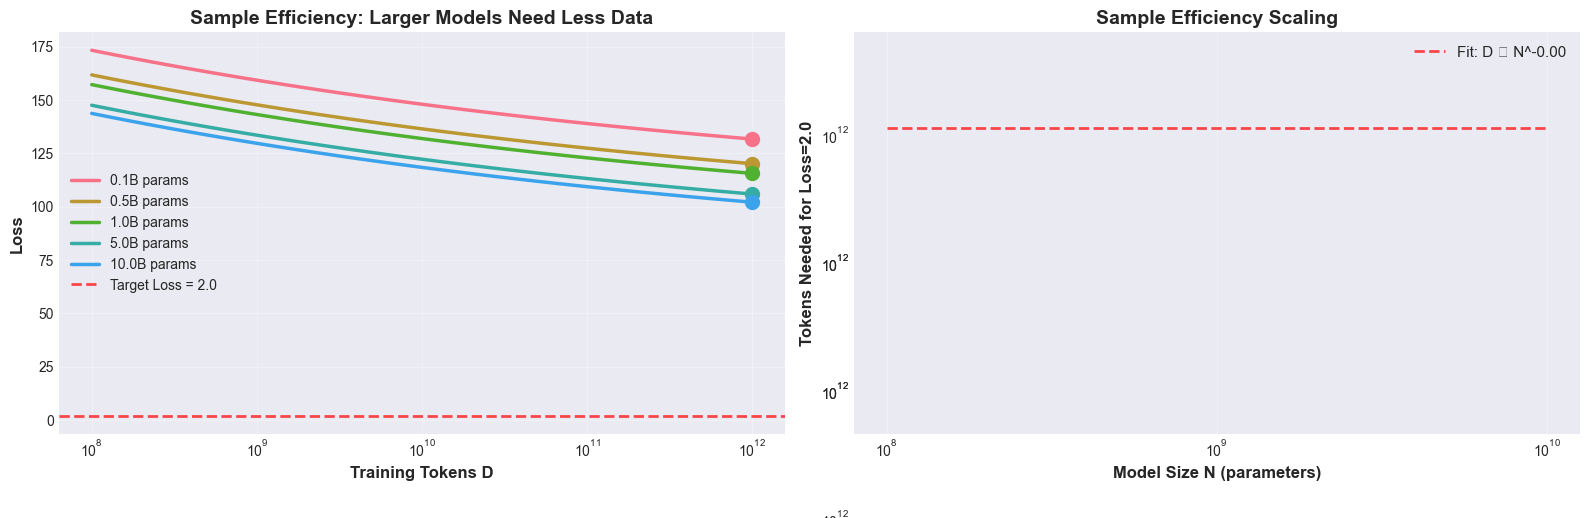

In [5]:
# Demonstrate sample efficiency
fig, axes = demonstrate_sample_efficiency(scaling)
plt.savefig('scaling_laws_sample_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

### Understanding Sample Efficiency

#### Plot 1: Training Curves
- Each line = a different model size
- The dots show where each model reaches the target loss (2.0)
- **Larger models reach the target with fewer tokens!**

#### Plot 2: Scaling of Sample Efficiency
- Shows tokens needed vs model size to reach target loss
- Power law relationship: D ∝ N^(negative exponent)
- **10x larger model → ~5-10x fewer training examples needed**

### Practical Implications

1. **Data-limited regimes**: If you can't get more data, use a larger model
2. **Faster iteration**: Large models converge faster → quicker experiments
3. **Quality over quantity**: Better to have a big model on good data than a small model on lots of mediocre data

### Caveat: The Training-Inference Trade-off

Sample efficiency explains why **some practitioners prefer over-sized models**:
- During development: larger models learn faster (less waiting)
- At deployment: can distill to smaller models for efficient serving

This is the rationale behind many "foundation model" strategies.

## Part 5: Practical Applications and Limitations

### When to Use Scaling Laws

✅ **Good Use Cases:**

1. **Resource Planning**: Estimate compute needed for target performance
2. **Budget Allocation**: Decide how to split $ between GPUs and data
3. **Performance Prediction**: Extrapolate from small pilot runs
4. **Strategy Selection**: Choose between training-optimal vs inference-optimal



### Limitations of Scaling Laws

❌ **What Scaling Laws DON'T Tell Us:**

1. **Emergent Capabilities**
   - Sudden improvements in reasoning, few-shot learning, etc.
   - These often appear as discontinuous jumps, not smooth curves

2. **Data Quality Effects**
   - Scaling laws assume uniform data quality
   - In reality: 1000 high-quality examples > 1M low-quality ones

3. **Architecture Choices**
   - Depth vs width, attention patterns, activation functions
   - Scaling laws are agnostic to these details

4. **Training Dynamics**
   - Stability, convergence speed, optimal hyperparameters
   - When training will fail or succeed

5. **Task-Specific Performance**
   - Only predict pre-training loss
   - Downstream task performance may not correlate perfectly

6. **Distribution Shifts**
   - Assume train/test from same distribution
   - Real-world: models face new distributions at deployment

### The Bottom Line

Scaling laws are **powerful guidelines**, not **fundamental laws of nature**:
- Use them for planning and prediction
- But don't let them replace empirical validation
- Always test on your specific use case!